In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import astropy as ast
from astropy.io import ascii
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#extinction imports
from astropy.table import Table, Column, MaskedColumn, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
# from dustmaps.sfd import SFDQuery
# from dustmaps.edenhofer2023 import Edenhofer2023Query
# sfd = SFDQuery()
# eden = Edenhofer2023Query(integrated=True)
# from view_and_clean import individual_plotter, df_extract, individual_plotter_v2, df_extract_v2, offset_corrector
from metrics import sed_plotter, info, observed_sed #, fit_plotter_flux, fit_plotter_flux_v2, mean_med_flux, mean_med_flux_v2, offset_warning, offset_warning_v2,compute_lomb_scargle, plot_periodogram, plot_phase_fold 

# Read in files (from pre-computing models, Anna's binary identification files, and the base paths to where you are storing the models)

In [2]:
# for ease of access I created this file that contains RA and DEC columns of both SMC and LMC YSG candidates combined:
coords = pd.read_csv('merged_smc_lmc_coords.csv', comment='#', sep="\\s+", names=['RA', 'DEC'])

# now Anna's binary candidates for both clouds:
smc_vis_binaries = pd.read_csv('./annas_candidates/smc_vis_bin.csv', comment='#')
smc_opt_binaries = pd.read_csv('./annas_candidates/smc_opt_bin.csv', comment='#') 
lmc_vis_binaries = pd.read_csv('./annas_candidates/lmc_vis_bin.csv', comment='#')
lmc_opt_binaries = pd.read_csv('./annas_candidates/lmc_opt_bin.csv', comment='#') 
# this is the file that contains the results of our variability analysis so far! 
# We load it here because it contains Anna's old T and L estimations and my estimations of the dominant period.
stats = pd.read_csv('summary_results15.csv')
# This is the results of fitting for the temperatures (comparing observed to synthetic photometry). Stores the best fits for every star
temp_stats = pd.read_csv('ysg_temp_fitting_summary_v2.csv')
# set serif font settings for plots
plt.rcParams['font.family'] = 'serif'

In [3]:
smcbasepath = './pysynphot_data/grid/bosz/r2000/m-0.75/'
lmcbasepath = './pysynphot_data/grid/bosz/r2000/m-0.25/'
wave=ascii.read('./pysynphot_data/grid/bosz/r2000/bosz2024_wave_r2000.txt', names=['wave'],data_start=0)

# Load in info about the filters (transmissions, zeropoints, and wavelengths)

In [4]:
# Load in filter functions
col_names=['lam','flux']

tmass_j = ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.J_v3.0596e-10_ab7.08741e-10_eff12350.dat', names=col_names, data_start=0)
tmass_h = ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.H_v1.11064e-10_ab4.00078e-10_eff16620.dat', names=col_names, data_start=0)
tmass_k = ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.Ks_v4.17999e-11_ab2.32482e-10_eff21590.dat', names=col_names, data_start=0)

mcps_U=ascii.read('./pysynphot_data/grid/bosz/Misc_MCPS.U_v4.08739e-9_ab8.23894e-9_eff3706.dat',names=col_names,data_start=0)
mcps_B=ascii.read('./pysynphot_data/grid/bosz/Misc_MCPS.B_v6.21086e-9_ab5.60999e-9_eff4394.dat', names=col_names,data_start=0)
mcps_V=ascii.read('./pysynphot_data/grid/bosz/Misc_MCPS.V_v3.64047e-9_ab3.63812e-9_eff5438.dat', names=col_names,data_start=0)
mcps_I=ascii.read('./pysynphot_data/grid/bosz/Misc_MCPS.I_v9.23651e-10_ab1.45234e-9_eff8568.dat', names=col_names,data_start=0)

swift_uvm1=ascii.read('./pysynphot_data/grid/bosz/Swift_UVOT.UVM2_trn_v4.66117e-9_ab2.15291e-8_eff2246.dat', names=col_names,data_start=0)
swift_uvw1=ascii.read('./pysynphot_data/grid/bosz/Swift_UVOT.UVW1_trn_v4.02204e-9_ab1.57569e-8_eff2715.dat', names=col_names,data_start=0)
swift_uvw2=ascii.read('./pysynphot_data/grid/bosz/Swift_UVOT.UVW2_trn_v5.37469e-9_2.59051e-8_eff2075.dat', names=col_names,data_start=0)    

# Vega zero points for conversion to ergs/s/cm^2/Angstrom
tmass_j_zp = 3.129e-10
tmass_h_zp = 1.133e-10
tmass_k_zp = 4.283e-11
mcps_U_zp = 4.08739e-9
mcps_B_zp = 6.21086e-9
mcps_V_zp = 3.64047e-9
mcps_I_zp = 9.23651e-10
swift_uvm1_zp = 4.66117e-9
swift_uvw1_zp = 4.02204e-9
swift_uvw2_zp = 5.37469e-9

# Band wavelengths for plotting
band_wavelengths = {
    'J': 12350.0,  
    'H': 16620.0,   
    'K': 21590.0,   
    'U': 3706.29,  
    'B': 4394.48,      
    'V': 5438.23,   
    'I': 8568.89,     
    'uvm2': 2246.56,  
    'uvw1': 2715.68,   
    'uvw2': 2075.69    
}

# Defining functions from Maria and Anna for computations...

In [5]:
# Functions

def synth_flux(filter_name,model_lam,model_flux):
    '''
    Calculates the synthetic photometric flux for the input model with the
    input filter transmission file.

    Parameters:
    filter_name: The filter file containing the wavelength (Angstroms) 
                    and intensity (erg/s/cm^2/A)
    model_lam: The model wavelengths in Angstroms
    model_flux: The model flux in erg/s/cm^2/A

    Returns:
    flux: The synthetic flux in erg/s/cm^2/A
    '''
    filter_lam = filter_name.columns[0]
    filter_flux = filter_name.columns[1]
    
    f_lam=np.zeros(len(filter_lam))
    for i in range(len(f_lam)):
        # This interpolates the model flux along the same wavelengths as the
        # transmission curve. This needs to be done for the integration to work
        f_lam[i]=np.interp(filter_lam[i],model_lam,model_flux)
    
    # Multiply the (interpolated) model flux by the filter intensity, and integrate
    top = np.trapezoid(np.multiply(f_lam,filter_flux),x=filter_lam)
    # Integrate the filter intensity alone
    bottom = np.trapezoid(filter_flux,x=filter_lam)
    # Divide!
    flux = top/bottom
    
    return flux


def flux_to_mag(flux,zp):
    '''
    Converts a flux to a magnitude given the zero point.

    Parameters:
    flux: flux in erg/s/cm^2/A
    zp: Zero point in erg/s/cm^2/A

    Returns:
    mag: Magnitude
    '''

    mag = (-2.5)*np.log10(flux/zp)

    return mag

def synth_mag(filter_name,model_lam,model_flux,zp):
    '''
    Calculates the synthetic magnitude for the input model using the input
    filter transmission and a zero point.

    Parameters:
    filter_name: The filter file containing the wavelength (Angstroms) 
                    and intensity (erg/s/cm^2/A)
    model_lam: The model wavelengths in Angstroms
    model_flux: The model flux in erg/s/cm^2/A
    zp: Zero point in erg/s/cm^2/A

    Returns:
    mag: Magnitude
    '''

    flux = synth_flux(filter_name,model_lam,model_flux)
    mag = flux_to_mag(flux,zp)
    return mag

def rchi2_with_err(star_mags,star_err,model_mags):
    '''
    Returns the reduced chi^2, accounting for errors
    Parameters:
        star_mags: Observed magnitudes
        star_err: Uncertainty on the observed magnitudes
        model_mags: Model magnitudes
    Returns:
        rchi2: Reduced chi^2 value
    '''
    N = len(star_mags)
    z = (star_mags-model_mags)/star_err
    rchi2 = np.sum(z**2)/(N-1)
    return rchi2

def Cardelli_redden(wave,flux,Av=0,Rv=3.1):
    '''Will redden an input spectrum based on the Cardelli law:
    
    Parameters:
    wave (angstrom): wavelengths of input spectrum in Angstrom
    flux (erg/s/cm/Ang): flux of spectrum; scaled version of this flux are fine.
    Av:
    Rv:
    
    Returns: a new flux array in same units as input
    '''

    wave_micon=wave*1.0e-4
    wave_inverse=1.0/wave_micon
    
    A_lambda=np.zeros(len(wave))
    ax=np.zeros(len(wave))
    bx=np.zeros(len(wave))
    
    for i in range(len(wave)):
        if((wave_inverse[i] > 0.3) and (wave_inverse[i] < 1.1)):
            ax[i]=0.574*wave_inverse[i]**1.61
            bx[i]=-0.527*wave_inverse[i]**1.61
        if((wave_inverse[i] > 1.1) and (wave_inverse[i] < 3.3)):
            y=wave_inverse[i] - 1.82
            ax[i]=1+ 0.17699*y - 0.50447*y**2. - 0.02427*y**3.+0.72085*y**4.+0.01979*y**5.-0.77530*y**6.+0.32999*y**7.
            bx[i]=1.41338*y+2.28305*y**2.+1.07233*y**3.-5.38434*y**4.-0.62251*y**5.+5.30260*y**6.-2.09002*y**7.
        if((wave_inverse[i] > 3.3) and (wave_inverse[i] < 8.0)):
            if(wave_inverse[i] > 5.9):
                Fa=-0.04473*(wave_inverse[i] - 5.9)**2.-0.009779*(wave_inverse[i]-5.9)**3.
                Fb=0.2130*(wave_inverse[i] - 5.9)**2. +0.1207*(wave_inverse[i] -5.9)**3.
            else:
                Fa = 0.0
                Fb = 0.0

            ax[i]=1.752 - 0.316*wave_inverse[i]-0.104/((wave_inverse[i]-4.67)**2.+0.341) +Fa
            bx[i]=-3.090+1.825*wave_inverse[i]+1.206/((wave_inverse[i] - 4.62)**2.+0.263) +Fb

    A_lambda=(ax+bx/Rv)*Av
    #print(A_lambda)
    NewSpec=flux*10.**(-0.4*A_lambda)
    results = NewSpec
    return results

def compute_synth_photometry(ex_wave, ex_flux):
    jmag=synth_mag(tmass_j,ex_wave['wave'],ex_flux['flux'],tmass_j_zp)
    hmag=synth_mag(tmass_h,ex_wave['wave'],ex_flux['flux'],tmass_h_zp)
    kmag=synth_mag(tmass_k,ex_wave['wave'],ex_flux['flux'],tmass_k_zp)
    Umag=synth_mag(mcps_U,ex_wave['wave'],ex_flux['flux'],mcps_U_zp)
    Bmag=synth_mag(mcps_B,ex_wave['wave'],ex_flux['flux'],mcps_B_zp)
    Vmag=synth_mag(mcps_V,ex_wave['wave'],ex_flux['flux'],mcps_V_zp)
    Imag=synth_mag(mcps_I,ex_wave['wave'],ex_flux['flux'],mcps_I_zp)
    uvm2_mag=synth_mag(swift_uvm1,ex_wave['wave'],ex_flux['flux'],swift_uvm1_zp)
    uvw1_mag=synth_mag(swift_uvw1,ex_wave['wave'],ex_flux['flux'],swift_uvw1_zp)
    uvw2_mag=synth_mag(swift_uvw2,ex_wave['wave'],ex_flux['flux'],swift_uvw2_zp)
    model_mags=[jmag,hmag,kmag,Umag,Bmag,Vmag,Imag,uvm2_mag,uvw1_mag,uvw2_mag]

    #convert them to flux:
    jflux = tmass_j_zp * 10**(-0.4 * jmag)
    hflux = tmass_h_zp * 10**(-0.4 * hmag)
    kflux = tmass_k_zp * 10**(-0.4 * kmag)
    Uflux = mcps_U_zp * 10**(-0.4 * Umag)
    Bflux = mcps_B_zp * 10**(-0.4 * Bmag)
    Vflux = mcps_V_zp * 10**(-0.4 * Vmag)
    Iflux = mcps_I_zp * 10**(-0.4 * Imag)
    uvm2_flux = swift_uvm1_zp * 10**(-0.4 * uvm2_mag)
    uvw1_flux = swift_uvw1_zp * 10**(-0.4 * uvw1_mag)
    uvw2_flux = swift_uvw2_zp * 10**(-0.4 * uvw2_mag)
    model_fluxes=[jflux,hflux,kflux,Uflux,Bflux,Vflux,Iflux,uvm2_flux,uvw1_flux,uvw2_flux]

    # dictionary with band names as keys
    synth_phot = {
        'J': {'mag': jmag, 'flux': jflux},
        'H': {'mag': hmag, 'flux': hflux},
        'K': {'mag': kmag, 'flux': kflux},
        'U': {'mag': Umag, 'flux': Uflux},
        'B': {'mag': Bmag, 'flux': Bflux},
        'V': {'mag': Vmag, 'flux': Vflux},
        'I': {'mag': Imag, 'flux': Iflux},
        'uvm2': {'mag': uvm2_mag, 'flux': uvm2_flux},
        'uvw1': {'mag': uvw1_mag, 'flux': uvw1_flux},
        'uvw2': {'mag': uvw2_mag, 'flux': uvw2_flux}
    }
    return synth_phot

In [6]:
def get_ebv(ra,dec):
    """
    Collects E(B-V) values for a star location. Produces a 'minimum' E(B-V)
    from the Edenhofer 23 3D map, and a 'mean' E(B-V) from the SFD map,
    modified with the recalibration from SF 2011. 

    Parameters:
        ra - Right Ascension in decimal degrees
        dec - Declination in decimal degrees

    Returns:
        ebv_eden - Minimum E(B-V) from Edenhofer 23
        ebv_sf - 'Average' E(B-V) from SFD with the SF alteration
    
    """ 

    coords_eden=SkyCoord(ra*u.degree,dec*u.degree,
                         distance=1.24*u.kpc,frame='icrs') # Distance is max distance for this map
    ebv_eden=eden(coords_eden)

    coords_sf=SkyCoord(ra*u.degree,dec*u.degree,frame='icrs')
    ebv_sfd=sfd(coords_sf)
    ebv_sf=0.86*ebv_sfd # To fix from the older SFD value to the newer SF value

    return ebv_eden, ebv_sfd

def find_min_av(coords):

    # Set up EBV/Av holders
    ebv_eden=np.zeros(len(coords))
    ebv_sf=np.zeros(len(coords))
    av_eden=np.zeros(len(coords))
    av_sf=np.zeros(len(coords))

    # Rv values
    rv_gal=3.17
    rv_smc=3.02
    rv_lmc=3.41

    for i in range(len(coords)):
        ebv_eden_t, ebv_sf_t = get_ebv(coords.iloc[i]['RA'],coords.iloc[i]['DEC'])
        ebv_eden[i] = round(float(ebv_eden_t),5)
        ebv_sf[i] = round(float(ebv_sf_t),5)
        
        av_eden[i] = round((float(ebv_eden_t)*rv_gal),5)
        if coords.iloc[i]['RA'] > 40.0:
            av_sf[i] = round((float(ebv_sf_t)*rv_lmc),5)
        else:
            av_sf[i] = round((float(ebv_sf_t)*rv_smc),5)

    ext_tab = Table([coords['RA'],coords['DEC'],ebv_eden,ebv_sf,av_eden,av_sf],
            names=['RA','DEC','ebv_eden','ebv_sf','av_eden','av_sf'])
    # write to file
    ext_tab.write('ysg_candidate_extinctions.csv',format='csv',overwrite=True)
    return ext_tab

# find_min_av(coords)

# Main plotting functions to see SEDs and spectra, then histograms, for a given star:

Found 2 temperature variant models within 250K:
Available temperatures: [8250 8750]
Found 2 temperature variant models within 500K:
Available temperatures: [11500 12500]


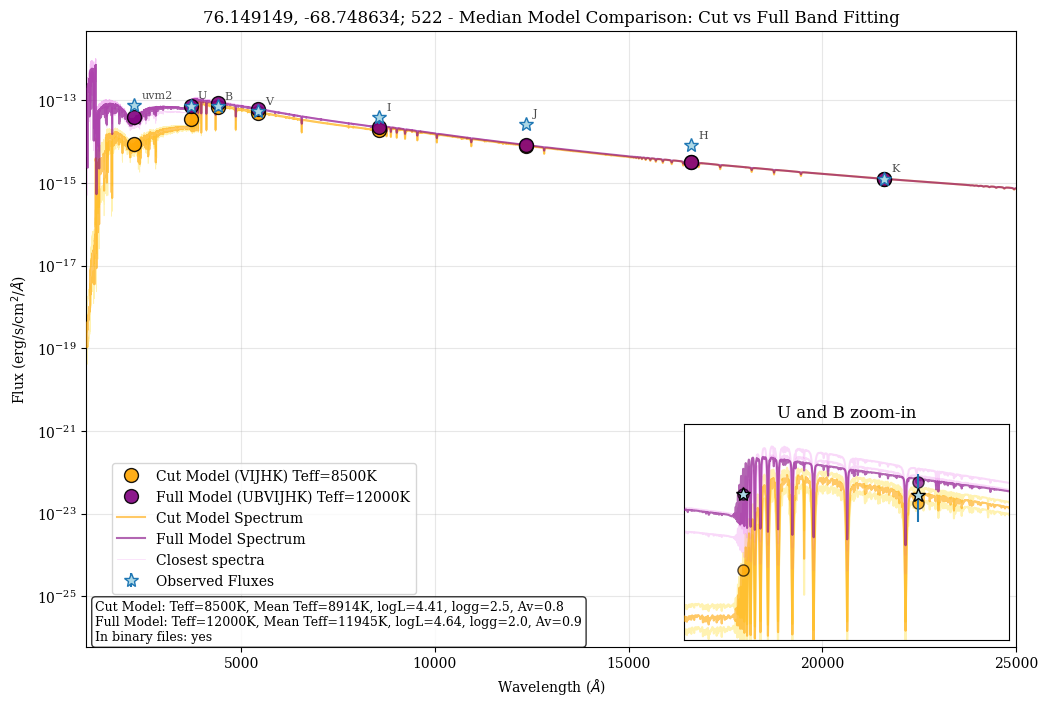

In [7]:
def fit_models_to_star_flux(star_idx): 
    """
    Fits the best model spectra (the median) to the observed SED of a given star index,
    comparing models based on median parameters from temp_stats.
    Optionally plots the observed SED and best-fit models.
    """  
    computed_models = pd.read_csv('synth_phot_all_models.csv')

    ######### grab the observed SED for the star
    obs = observed_sed(star_idx, show=False)
    obs_wavelengths, obs_fluxes, obs_flux_errors, obs_mags, obs_mag_errors, obs_band_names = obs
    
    available_bands = list(obs_band_names)  # Convert to list to ensure .index() method works
    
    band_to_filter = {
        'J': tmass_j, 'H': tmass_h, 'K': tmass_k,
        'U': mcps_U, 'B': mcps_B, 'V': mcps_V, 'I': mcps_I,
        'uvm2': swift_uvm1, 'uvw1': swift_uvw1, 'uvw2': swift_uvw2
    }     

    ########## determine the best fitting model to test based on medians in ysg_temp_fitting_summary_v2.csv
    # Best fitting full parameters:
    median_teff_full = temp_stats['teff_median_full'][star_idx]
    median_logg_full = temp_stats['logg_median_full'][star_idx]
    median_av_full = temp_stats['av_median_full'][star_idx]
    median_metallicity = -0.75 if star_idx < 377 else -0.25 # SMC if index < 377, else LMC
    #Best fitting cut parameters:
    median_teff_cut = temp_stats['teff_median_cut'][star_idx]
    median_logg_cut = temp_stats['logg_median_cut'][star_idx]
    median_av_cut = temp_stats['av_median_cut'][star_idx]


    # Filter models based on median parameters - separate the two model sets properly
    models_full = computed_models[
        (computed_models['teff'] == median_teff_full) &
        (computed_models['logg'] == median_logg_full) &
        (computed_models['av'] == median_av_full) &
        (computed_models['metallicity'] == median_metallicity)
    ]
    
    models_cut = computed_models[
        (computed_models['teff'] == median_teff_cut) &
        (computed_models['logg'] == median_logg_cut) &
        (computed_models['av'] == median_av_cut) &
        (computed_models['metallicity'] == median_metallicity)
    ]
    
    plot_data = []
    
    # Process both models (full and cut)
    for model_type, models in [('cut', models_cut), ('full', models_full)]:
        if len(models) == 0:
            print(f"No models found for {model_type}")
            continue
            
        # take the first (should be only) model
        model = models.iloc[0]
        
        # load model spectrum
        model_spectrum = ascii.read(model['model'], names=['flux','cont'], data_start=0)
        model_flux = Cardelli_redden(wave['wave'], model_spectrum['flux'], Av=model['av'])
        
        # calculate synthetic fluxes for available bands using the model
        model_fluxes = np.array([synth_flux(band_to_filter[band], wave['wave'], model_flux) for band in available_bands])
        
        # Determine reference band for flux scaling (prefer K, then H)
        if 'K' in available_bands:
            ref_band = 'K'
        else:
            print('No K band found in observed bands.')
            return
        
        ref_idx = available_bands.index(ref_band)
        
        # Calculate scaling factor using reference band
        flux_scale = obs_fluxes[ref_idx] / model_fluxes[ref_idx]
        
        # Scale model fluxes and spectrum
        scaled_model_fluxes = model_fluxes * flux_scale
        scaled_model_spectrum = model_flux * flux_scale
        
        # Calculate luminosity from scaling
        luminosity = model['lum_unscaled'] * flux_scale
        logL = np.log10(luminosity / 3.826e33)  # solar lum in erg/s
        
        # Get wavelengths for plotting
        plot_wavelengths = [band_wavelengths[band] for band in available_bands]
        
        # Store data for plotting
        plot_data.append({
            'model_type': model_type,
            'model': model,
            'scaled_model_fluxes': scaled_model_fluxes,
            'scaled_model_spectrum': scaled_model_spectrum,
            'plot_wavelengths': plot_wavelengths,
            'obs_fluxes': obs_fluxes,
            'available_bands': available_bands,
            'logL': logL,
            'luminosity': luminosity
        })


    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    RA = coords['RA'].iloc[star_idx]
    dec = coords['DEC'].iloc[star_idx]
    
    # Plot observed data points 
    ax.errorbar(obs_wavelengths, obs_fluxes, yerr=obs_flux_errors,
                ms=10, fmt='*', mec='C0', mfc='lightblue', ecolor='C0', label='Observed Fluxes', zorder=10)
    
    # Plot cut bands model 
    data_cut = plot_data[0]
    ax.plot(data_cut['plot_wavelengths'], data_cut['scaled_model_fluxes'],
            'o', ms=10, mec='k', mfc='orange', alpha=0.9, label='Cut Model (VIJHK) Teff={:.0f}K'.format(data_cut['model']['teff']), zorder=8)
    
    # Plot full bands model 
    data_full = plot_data[1] 
    ax.plot(data_full['plot_wavelengths'], data_full['scaled_model_fluxes'],
            'o', ms=10, mec='k', mfc='purple', alpha=0.9, label='Full Model (UBVIJHK) Teff={:.0f}K'.format(data_full['model']['teff']), zorder=8)
    
    # band labels for observed points
    for i, (wl, flux, band) in enumerate(zip(obs_wavelengths, obs_fluxes, obs_band_names)):
        ax.annotate(band, (wl, flux), xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.7)
    
    # model spectra in background
    ax.plot(wave['wave'], data_cut['scaled_model_spectrum'],
            '-', color='orange', alpha=0.6, label='Cut Model Spectrum', zorder=5)
    ax.plot(wave['wave'], data_full['scaled_model_spectrum'],
            '-', color='purple', alpha=0.6, label='Full Model Spectrum', zorder=5)
    
    ax.grid(True, alpha=0.3)

    # inset axes in the lower right corner
    axins = inset_axes(ax, width="35%", height="35%", loc='lower right')

    # Plot the zoom to U and B band region
    axins.errorbar(obs_wavelengths, obs_fluxes, yerr=obs_flux_errors,
                ms=10, fmt='*', mec='k', mfc='lightblue', ecolor='C0', zorder=10)
    axins.plot(data_cut['plot_wavelengths'], data_cut['scaled_model_fluxes'],
            'o', ms=8, mec='k', mfc='orange', alpha=0.7, zorder=8)
    axins.plot(data_full['plot_wavelengths'], data_full['scaled_model_fluxes'],
            'o', ms=8, mec='k', mfc='purple', alpha=0.7, zorder=8)
    axins.plot(wave['wave'], data_cut['scaled_model_spectrum'],
            '-', color='orange', alpha=0.6, label='Cut Model Spectrum', zorder=5)
    axins.plot(wave['wave'], data_full['scaled_model_spectrum'],
            '-', color='purple', alpha=0.6, label='Full Model Spectrum', zorder=5)

    # Set zoom limits around U band
    axins.set_xlim(3500, 4800) 
    # Get U band flux values specifically
    u_idx_cut = data_cut['available_bands'].index('U')
    u_idx_full = data_full['available_bands'].index('U')
    u_idx_obs = np.where(obs_band_names == 'U')[0][0]
    
    u_fluxes = [
        data_cut['scaled_model_fluxes'][u_idx_cut],
        data_full['scaled_model_fluxes'][u_idx_full],
        obs_fluxes[u_idx_obs]
    ]
    
    minimum = np.min(u_fluxes) * 0.5  
    maximum = np.max(u_fluxes) * 2.0  
    axins.set_ylim(minimum, maximum)  # Set appropriate flux range
    axins.set_yscale('log')
    axins.set_xscale('log')
    # Remove all tick labels and ticks - must be done AFTER setting scales
    axins.set_xticks([])
    axins.set_yticks([])
    axins.tick_params(axis='both', which='both', bottom=False, top=False, 
                        left=False, right=False, labelbottom=False, labeltop=False,
                        labelleft=False, labelright=False, length=0)
    # Add title to inset
    axins.set_title('U and B zoom-in', fontsize=12, pad=5) 
    
    # Plot additional models within +/-500K range
    for model_type, main_data, color in [('cut', data_cut, 'gold'), ('full', data_full, 'violet')]:
        best_teff = main_data['model']['teff']
        best_logg = main_data['model']['logg']
        best_av = main_data['model']['av']
        best_metallicity = main_data['model']['metallicity']
        
        # Determine temperature increment based on the model grid: 250K below 12000K, 500K at/above 12000K
        if best_teff < 12000:
            temp_increment = 250
        else:
            temp_increment = 500
        
        # Find temperature variants: one below and one above the best fit
        temp_low = best_teff - temp_increment
        temp_high = best_teff + temp_increment
        
        # Determine allowed logg values based on temperature
        # At 12000K: logg can be 2.5 or 3.0
        # At 12500K and above: only logg = 3.0 is possible
        allowed_logg = [best_logg]  # Always include the best fit logg
        
        if temp_low == 12000 or temp_high == 12000:
            # At 12000K, allow both 2.5 and 3.0
            if 2.5 not in allowed_logg:
                allowed_logg.append(2.5)
            if 3.0 not in allowed_logg:
                allowed_logg.append(3.0)
        elif temp_high >= 12500:
            # At 12500K and above, only logg=3.0
            allowed_logg = [3.0]
        
        temp_models = computed_models[
            ((computed_models['teff'] == temp_low) | (computed_models['teff'] == temp_high)) &
            (computed_models['logg'].isin(allowed_logg)) &  # Surface gravity in allowed range
            (computed_models['av'] == best_av) &       # Same extinction
            (computed_models['metallicity'] == best_metallicity)
        ]
        print(f"Found {len(temp_models)} temperature variant models within {temp_increment}K:")
        print(f"Available temperatures: {temp_models['teff'].unique()}")
        
        # Limit to the two closest temperature variants
        temp_models = temp_models.head(2)
        
        for r, temp_model in temp_models.iterrows():
            try:
                # Load and process temperature variant model
                temp_spectrum = ascii.read(temp_model['model'], names=['flux','cont'], data_start=0)
                temp_flux = Cardelli_redden(wave['wave'], temp_spectrum['flux'], Av=temp_model['av'])
                
                # Calculate fluxes for common bands using the same mapping
                temp_model_fluxes = np.array([synth_flux(band_to_filter[band], wave['wave'], temp_flux) for band in available_bands])
                
                # Scale using same reference band as main model (ref_band and ref_idx already determined)
                main_ref_idx = main_data['available_bands'].index(ref_band)
                obs_ref_flux = main_data['obs_fluxes'][main_ref_idx]
                temp_flux_scale = obs_ref_flux / temp_model_fluxes[ref_idx]
                
                # Plot the scaled spectrum with very light alpha
                temp_scaled_spectrum = temp_flux * temp_flux_scale
                ax.plot(wave['wave'], temp_scaled_spectrum,
                        '-', color=color, alpha=0.3, linewidth=0.5)
                axins.plot(wave['wave'], temp_scaled_spectrum,
                '-', color=color, alpha=0.3)
                
            except Exception as e:
                print(f"Warning: could not process temperature variant model {temp_model['teff']}K: {e}")
                continue
    # Just replot the last one for 1 label to appear in the legend
    ax.plot(wave['wave'], temp_scaled_spectrum,
                        '-', color=color, alpha=0.3, linewidth=0.5, label = 'Closest spectra')
    
    # Check if star is in binary candidate files
    tolerance = 1e-5  # Small tolerance for coordinate matching
    in_optsmc = ((np.abs(smc_opt_binaries['ra'] - RA) < tolerance) & 
                (np.abs(smc_opt_binaries['dec'] - dec) < tolerance)).any()
    in_optlmc = ((np.abs(lmc_opt_binaries['ra'] - RA) < tolerance) & 
                (np.abs(lmc_opt_binaries['dec'] - dec) < tolerance)).any()
    in_vissmc = ((np.abs(smc_vis_binaries['ra'] - RA) < tolerance) & 
                (np.abs(smc_vis_binaries['dec'] - dec) < tolerance)).any()
    in_vislmc = ((np.abs(lmc_vis_binaries['ra'] - RA) < tolerance) & 
                (np.abs(lmc_vis_binaries['dec'] - dec) < tolerance)).any()
    in_binary_files = "yes" if (in_optsmc or in_vissmc or in_optlmc or in_vislmc) else "no"
    
    # Add annotation with both model parameters
    annotation_text = ('Cut Model: Teff={:.0f}K, Mean Teff={:.0f}K, logL={:.2f}, logg={:.1f}, Av={:.1f}\n'
                        'Full Model: Teff={:.0f}K, Mean Teff={:.0f}K, logL={:.2f}, logg={:.1f}, Av={:.1f}\n'
                        'In binary files: {}').format(
                        data_cut['model']['teff'], temp_stats.iloc[star_idx]['teff_mean_cut'], data_cut['logL'], data_cut['model']['logg'], data_cut['model']['av'],
                        data_full['model']['teff'], temp_stats.iloc[star_idx]['teff_mean_full'], data_full['logL'], data_full['model']['logg'], data_full['model']['av'],
                        in_binary_files)
    
    ax.annotate(annotation_text, xy=(0.01, 0.075), xycoords='axes fraction', 
                va='top', color='black', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    ax.set_xlabel(r'Wavelength ($\AA$)')
    ax.set_ylabel(r'Flux (erg/s/cm$^{2}$/$\AA$)')
    ax.set_title(f'{RA}, {dec}; {star_idx} - Median Model Comparison: Cut vs Full Band Fitting')
    ax.set_xlim(1000, 25000)
    ax.set_yscale('log')
    y_min = min(np.min(data_cut['scaled_model_fluxes']), np.min(data_full['scaled_model_fluxes']))
    # ax.set_ylim(bottom=np.log10(y_min))
    ax.legend(loc='lower left', bbox_to_anchor=(0.02, 0.075))
    return

fit_models_to_star_flux(star_idx=522)

Found 3 temperature variant models within 250K:
Available temperatures: [7750 8250]
Found 2 temperature variant models within 500K:
Available temperatures: [11500 12500]


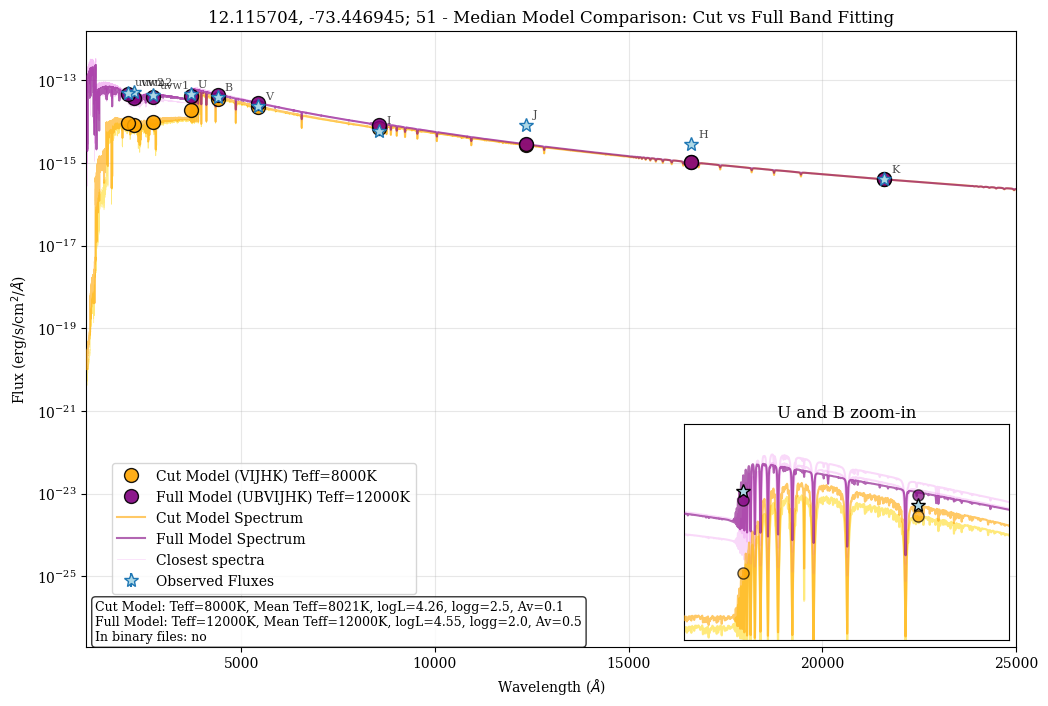

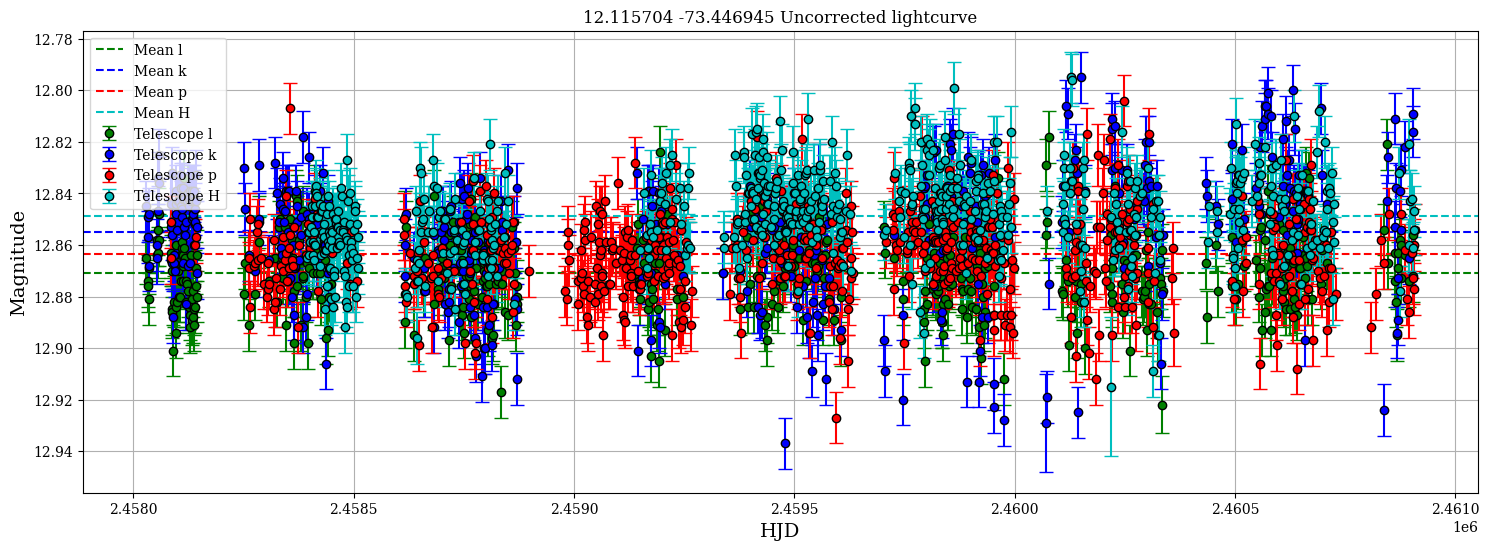

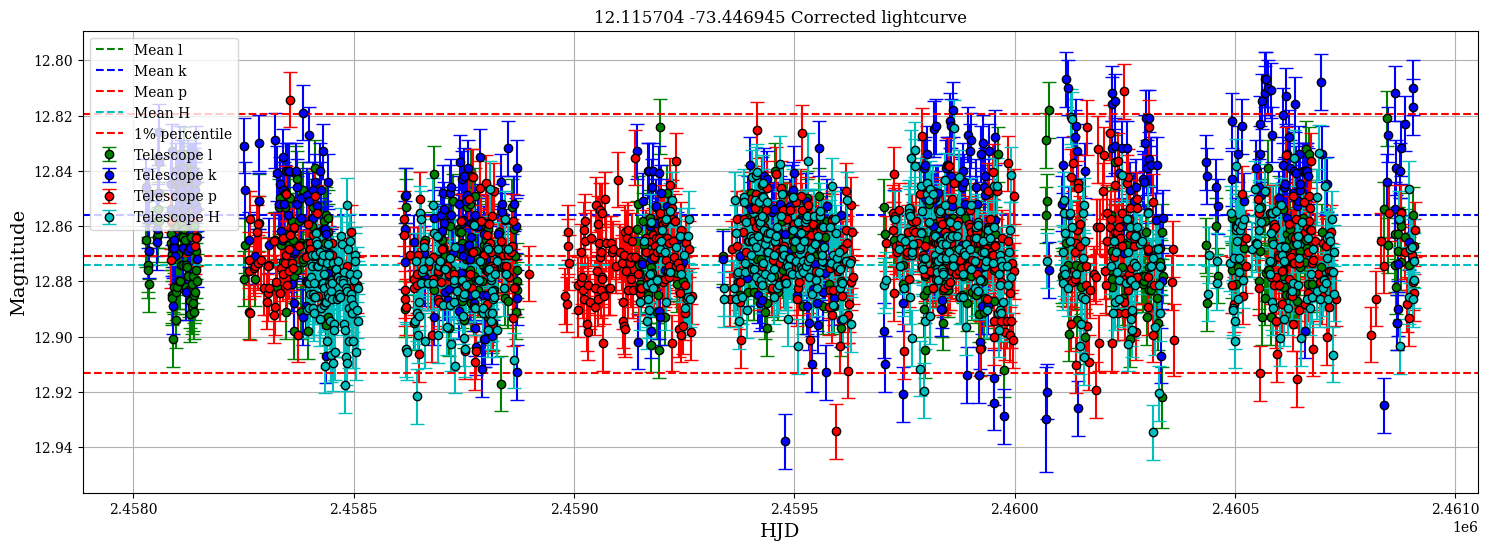

Best frequency: 0.003972 1/day, Best period: 251.78 days, Max power: 0.138, False alarm probability: 1.690e-65
False alarm level for 1.0%: 1.354e-02
Grid sampled at 19487 points


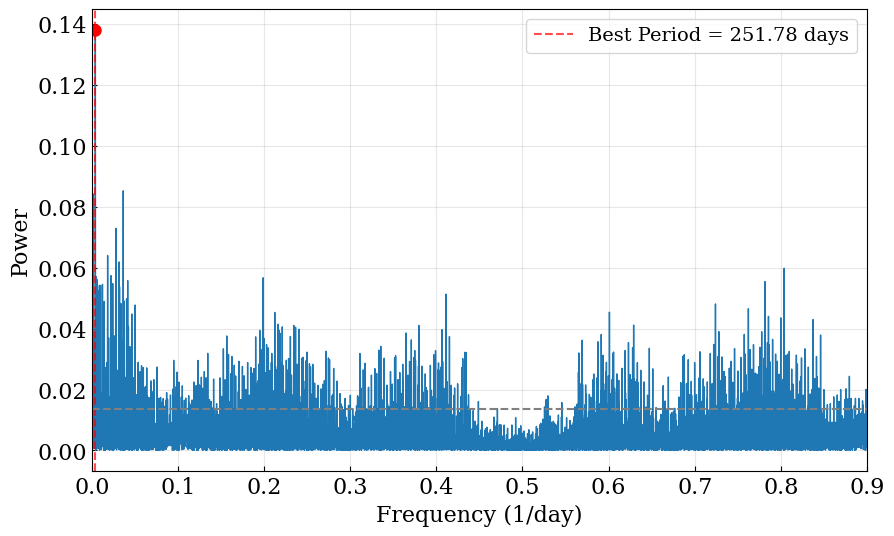

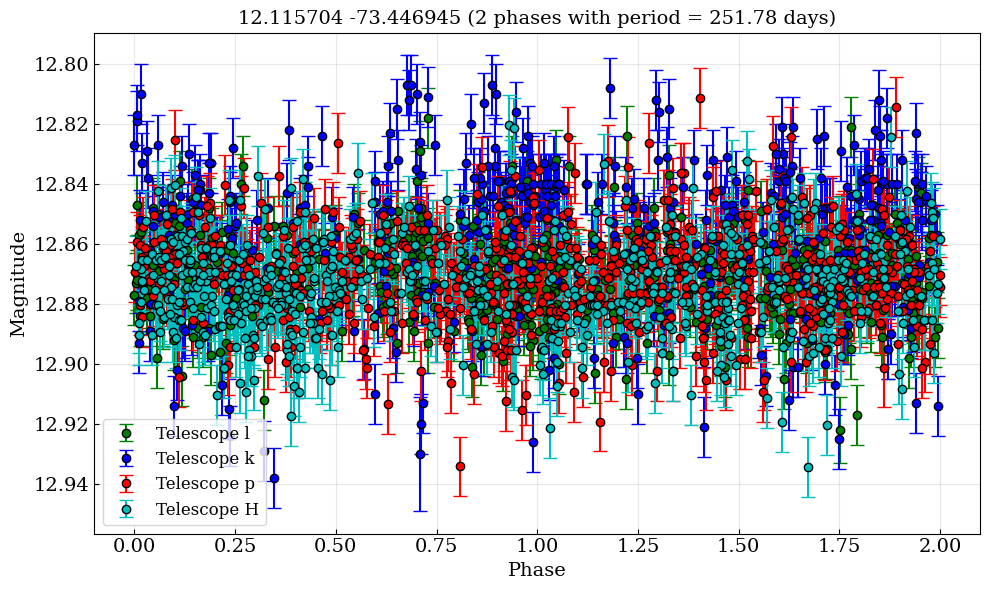

Average scatter (amplitude) per 10 point phase bin: 1.310 mJy


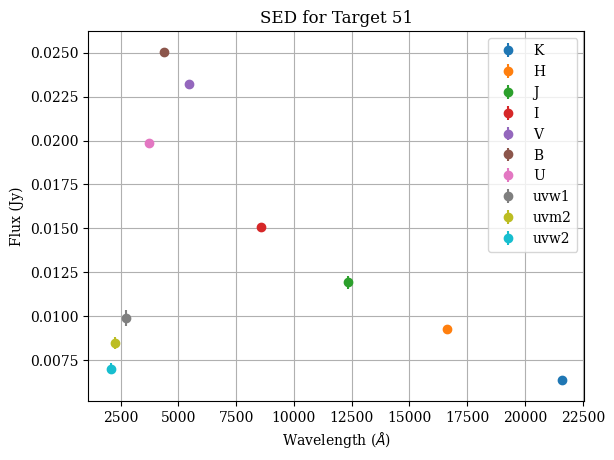

[0.00115648 0.00203336 0.00346405 0.00397172 0.00480244 0.00595622
 0.00664849 0.00738692 0.00826379 0.0087253  0.00946373 0.00992524
 0.01080211 0.01135593 0.01223281 0.01269432 0.01343274 0.01426347
 0.01472498 0.0154634  0.01610952 0.01735561 0.01823248 0.01938626
 0.02021699 0.02123232 0.02215534 0.02335528 0.02413985 0.0256167
 0.02607821 0.02690893 0.02764735 0.02810887 0.02893959 0.02953956
 0.03037028 0.0308318  0.03161637 0.03244709 0.03364703 0.03429315
 0.03553923 0.03636996 0.03683147 0.03756989 0.03840062 0.03941595
 0.04029282 0.04107739 0.04153891 0.04236963 0.04375417 0.04421569
 0.04550792 0.0462925  0.04772319 0.0498     0.05026151 0.05146145
 0.05372286 0.05418438 0.05579967 0.05764573 0.0585226  0.05972254
 0.06156859 0.06239931 0.0636454  0.06447612 0.06586066 0.06632218
 0.06752211 0.06839899 0.06982968 0.07186034 0.072368   0.0757832
 0.07790616 0.07970607 0.08182903 0.08279821 0.08385969 0.08575189
 0.08676722 0.08778255 0.09119775 0.09392068 0.09498216 0.096228

In [8]:
star_idx = 51
fit_models_to_star_flux(star_idx) #522, 417, 514, 51, 220, 283, 170, 429, 748, 675, 496

# comment this out if you didn't downloaded the YSG lightcurves from Ben!
info(star_idx)

In [9]:
def histo(index):
    RA = coords['RA'].iloc[index]
    dec = coords['DEC'].iloc[index]
    binwidth = 250
    final_teff_full = temp_stats['teff_mean_full'].iloc[index]
    final_teff_cut = temp_stats['teff_mean_cut'].iloc[index]
    output_filename_full = f'temp_fitting/{RA}_{dec}_full.parquet'
    output_filename_cut = f'temp_fitting/{RA}_{dec}_cut.parquet'
    # read parquet file:
    model_fitting_full = pd.read_parquet(output_filename_full)
    model_fitting_cut = pd.read_parquet(output_filename_cut)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    
    # Create bins that properly include the max value
    bins_full = range(min(model_fitting_full['teff']) - (binwidth//2), 
                      max(model_fitting_full['teff']) + binwidth//2 + 1, binwidth)
    bins_cut = range(min(model_fitting_cut['teff']) - binwidth//2, 
                     max(model_fitting_cut['teff']) + binwidth//2 + 1, binwidth)
    bins_full_logg = int((max(model_fitting_full['logg']) - min(model_fitting_full['logg'])) * 2.0)
    bins_cut_logg = int((max(model_fitting_cut['logg']) - min(model_fitting_cut['logg'])) * 2.0)
    # Ensure minimum number of bins
    bins_full_logg = max(bins_full_logg, 1)
    bins_cut_logg = max(bins_cut_logg, 1)  
    
    # Top row - 'full' plots in blue
    axes[0, 0].hist(model_fitting_full['teff'], bins=bins_full, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 0].annotate(f'Average Teff = {final_teff_full:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_full_mean"]:.3f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
    axes[0, 0].set_xlabel('$T_{eff}$ (K)', fontsize=16)
    axes[0, 0].set_ylabel('Counts')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].hist(model_fitting_full['logL'], bins=len(bins_full), color='blue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('log($L/L_{\\odot})$', fontsize=16)
    axes[0, 1].set_ylabel('Counts')
    axes[0, 1].grid(True, alpha=0.3)

    # Define custom bin edges for A_v and log(g)
    av_bins = np.arange(-0.05, 1.15, 0.1)  # Centers on 0, 0.1, 0.2, ..., 1.0
    logg_bins = np.arange(-0.25, 3.75, 0.5)  # Centers on 0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0

    axes[0, 2].hist(model_fitting_full['av'], bins=av_bins, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 2].set_xlabel('$A_v$', fontsize=16)
    axes[0, 2].set_ylabel('Counts')
    axes[0, 2].grid(True, alpha=0.3)

    axes[0, 3].hist(model_fitting_full['logg'], bins=logg_bins, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 3].set_xlabel('log(g)', fontsize=16)
    axes[0, 3].set_ylabel('Counts')
    axes[0, 3].grid(True, alpha=0.3)
    
    # Bottom row - 'cut' plots in green
    axes[1, 0].hist(model_fitting_cut['teff'], bins=bins_cut, color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].annotate(f'Average Teff = {final_teff_cut:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_cut_mean"]:.3f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
    axes[1, 0].set_xlabel('$T_{eff}$ (K)', fontsize=16)
    axes[1, 0].set_ylabel('Counts')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].hist(model_fitting_cut['logL'], bins=len(bins_cut), color='green', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('log($L/L_{\\odot}$)', fontsize=16)
    axes[1, 1].set_ylabel('Counts')
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].hist(model_fitting_cut['av'], bins=av_bins, color='green', alpha=0.7, edgecolor='black')
    axes[1, 2].set_xlabel('$A_v$', fontsize=16)
    axes[1, 2].set_ylabel('Counts')
    axes[1, 2].grid(True, alpha=0.3)

    axes[1, 3].hist(model_fitting_cut['logg'], bins=logg_bins, color='green', alpha=0.7, edgecolor='black')
    axes[1, 3].set_xlabel('log(g)', fontsize=16)
    axes[1, 3].set_ylabel('Counts')
    axes[1, 3].grid(True, alpha=0.3)
    
    # Add row labels
    fig.text(-0.005, 0.75, 'Fitting to UBVIJHK', rotation=90, fontsize=16, va='center', ha='center')
    fig.text(-0.005, 0.25, 'Fitting to VIJHK', rotation=90, fontsize=16, va='center', ha='center')
    fig.text(0.4,-0.02, f'{RA}, {dec}', fontsize=22)
    
    plt.tight_layout()
    plt.show()

# comment this in if you downloaded the parquet files!
# histo(0)

# Just looking at model spectra (checking for differences between different atmosphere models):

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_12573/233342101.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


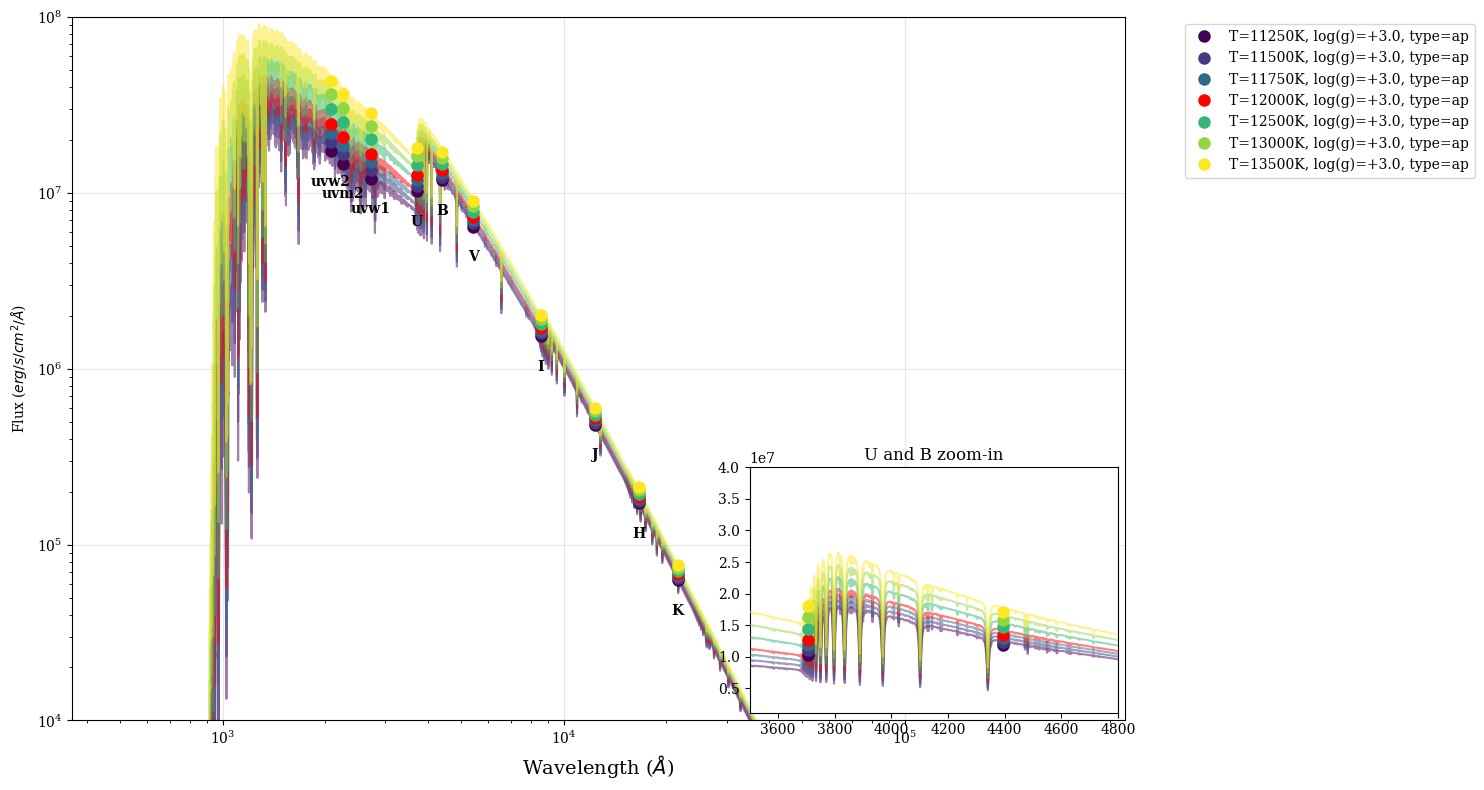

In [16]:
filenames_to_test = [
#     './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t6000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
#     './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t7000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    # './pysynphot_data/grid/bosz/r2000/m-0.75/bosz2024_ms_t7500_g+2.0_m-0.75_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    # './pysynphot_data/grid/bosz/r2000/m-0.75/bosz2024_ap_t7500_g+2.0_m-0.75_a+0.00_c+0.00_v2_r2000_resam.txt.gz']
    # './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t8000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    # './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t8000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz']
    # './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t9000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    # './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t10000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',


    './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t11250_g+3.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t11500_g+3.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t11750_g+3.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t12000_g+3.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',    
    './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t12500_g+3.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t13000_g+3.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t13500_g+3.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz']
# Define the correct order and names to match compute_synth_photometry output
synth_band_names = ['J', 'H', 'K', 'U', 'B', 'V', 'I', 'uvm2', 'uvw1', 'uvw2']
synth_wavelengths = [band_wavelengths[band] for band in synth_band_names]

fig, ax = plt.subplots(figsize=(15, 8))
# inset axes in the lower right corner
axins = inset_axes(ax, width="35%", height="35%", loc='lower right')
axins.set_title('U and B zoom-in', fontsize=12, pad=5) 
colors = plt.cm.viridis(np.linspace(0, 1, len(filenames_to_test)))

# Store first model's magnitudes for band labeling
first_model_mags = None
first_model_flux = None

for i, model in enumerate(filenames_to_test):
    data = np.loadtxt(model)
    # Create a dictionary-like structure that the function expects
    flux_data = {'flux': data[:,0]}
    synth_phot = compute_synth_photometry(wave, flux_data) 
    points_mag = [synth_phot[band]['mag'] for band in synth_band_names]
    points_flux = [synth_phot[band]['flux'] for band in synth_band_names]
    
    # Store first model's magnitudes for consistent band labeling
    if i == 0:
        first_model_mags = points_mag
        first_model_flux = points_flux
    
    # Parse model parameters from filename for label
    import re
    match = re.search(r't(\d+)_g([+-]?\d+\.?\d*)', os.path.basename(model))
    if match:
        teff = match.group(1)
        logg = match.group(2)
        atmosphere_type = 'ms' if 'ms' in os.path.basename(model) else 'ap'
        model_label = f'T={teff}K, log(g)={logg}, type={atmosphere_type}'
    else:
        model_label = os.path.basename(model)
    if teff == '12000':
        ax.plot(synth_wavelengths, points_flux, 'o', color='red', 
            label=model_label, markersize=8, linewidth=2, zorder = 10)
        ax.plot(wave['wave'], flux_data['flux'], color='red', alpha=0.5)
        axins.plot(wave['wave'], flux_data['flux'], color='red', alpha=0.5, zorder=10)
        axins.plot(synth_wavelengths, points_flux, 'o', color='red', 
                label=model_label, markersize=8, linewidth=2, zorder = 11)
    else:
        ax.plot(wave['wave'], flux_data['flux'], color=colors[i], alpha=0.5)
        ax.plot(synth_wavelengths, points_flux, 'o', color=colors[i], 
                label=model_label, markersize=8, linewidth=2, zorder = 10)
        # Plot the zoom to U and B band region
        axins.plot(wave['wave'], flux_data['flux'], color=colors[i], alpha=0.5, zorder=10)
        axins.plot(synth_wavelengths, points_flux, 'o', color=colors[i], 
                label=model_label, markersize=8, linewidth=2, zorder = 11)
    # Add band name labels only once, using the first model's positions
for j, (wl, mag, band) in enumerate(zip(synth_wavelengths, first_model_mags, synth_band_names)):
    ax.annotate(band, (wl, mag), xytext=(20, 5), textcoords='offset points', 
               fontsize=10, ha='center', fontweight='bold')
for j, (wl, mag, band) in enumerate(zip(synth_wavelengths, first_model_flux, synth_band_names)):
    ax.annotate(band, (wl, mag), xytext=(0, -25), textcoords='offset points', 
               fontsize=10, ha='center', fontweight='bold')
    


# Set zoom limits around U band
axins.set_xlim(3500, 4800)
axins.set_ylim(1e6, 4e7)  # Set appropriate flux range 


ax.set_xlabel('Wavelength ($\\AA$)', fontsize=14)
# ax.set_ylabel('Magnitude', fontsize=14)
ax.set_ylabel('Flux ($erg/s/cm^2/\\AA$)')
# ax.set_xlim(0,40000)
ax.set_ylim(1e4,1e8)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_title('Synthetic Photometry - BOSZ Models (T=4000K, varying log(g))', fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# comparing similar models but ap and ms atmospheres:
ms = './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t8000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz'
ap = './pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t8000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz'


# Overall properties of YSGs from SED fitting results:

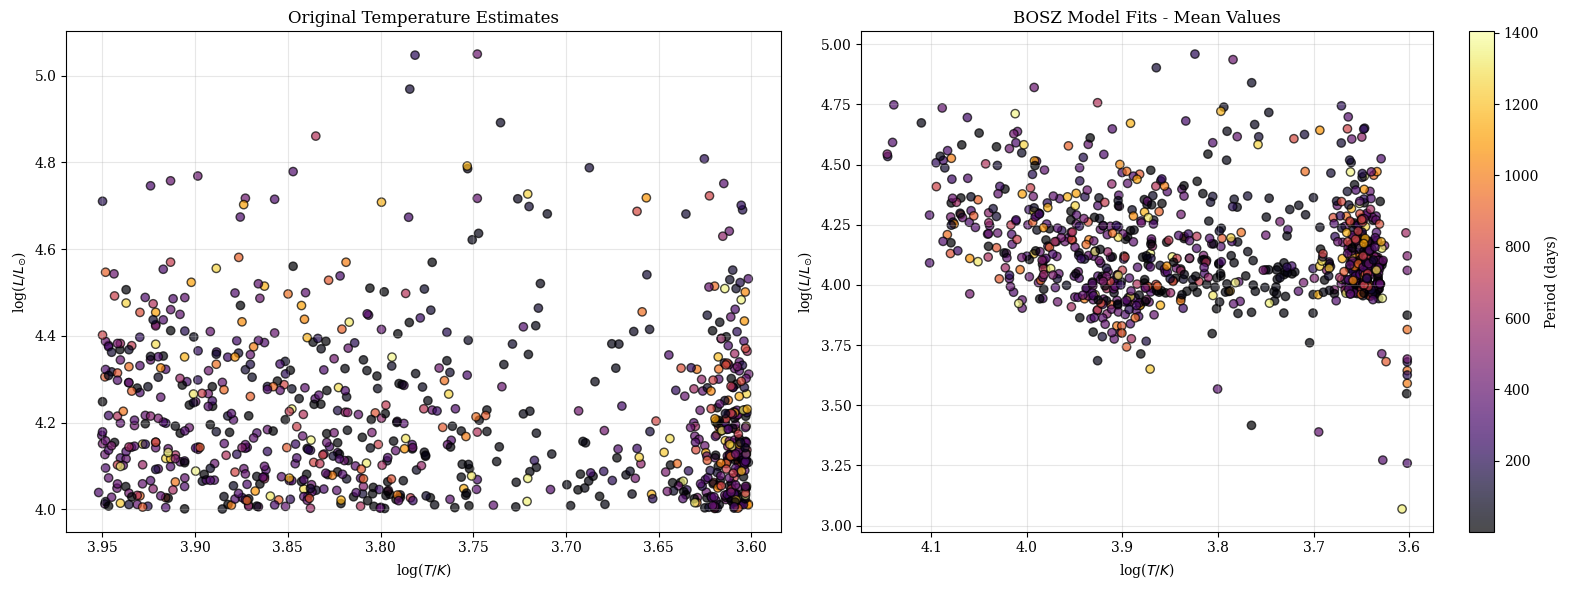

In [12]:
def HR_comparison(cut=True):
    if cut ==True: # show results from fitting to cut bands
        logT = temp_stats['logT_mean_cut']
        logL = temp_stats['logL_mean_cut']
    else: # show results from fitting to all bands
        logT = temp_stats['logT_mean_full']
        logL = temp_stats['logL_mean_full'] 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Old estimations
    periods = stats['best_period']
    x_old = stats['logT']
    y_old = stats['logL']
    sc1 = ax1.scatter(x_old, y_old, c=periods, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')
    ax1.set_xlabel('log($T/K$)')
    ax1.set_ylabel('log($L/L_{\\odot}$)')
    ax1.set_title('Original Temperature Estimates')
    ax1.invert_xaxis()
    ax1.grid(True, alpha=0.3)

    sc = ax2.scatter(logT, logL, c=periods, edgecolor='k', label='new estimations', alpha=0.7, cmap='inferno')
    ax2.set_xlabel('log($T/K$)')
    ax2.set_ylabel('log($L/L_{\\odot}$)')
    ax2.set_title('BOSZ Model Fits - Mean Values')
    ax2.invert_xaxis()
    ax2.grid(True, alpha=0.3)
    cbar = plt.colorbar(sc, ax=ax2)
    cbar.set_label('Period (days)')
    plt.tight_layout()
    # plt.savefig('HR_comparison.png', bbox_inches='tight')
    plt.show()
HR_comparison()

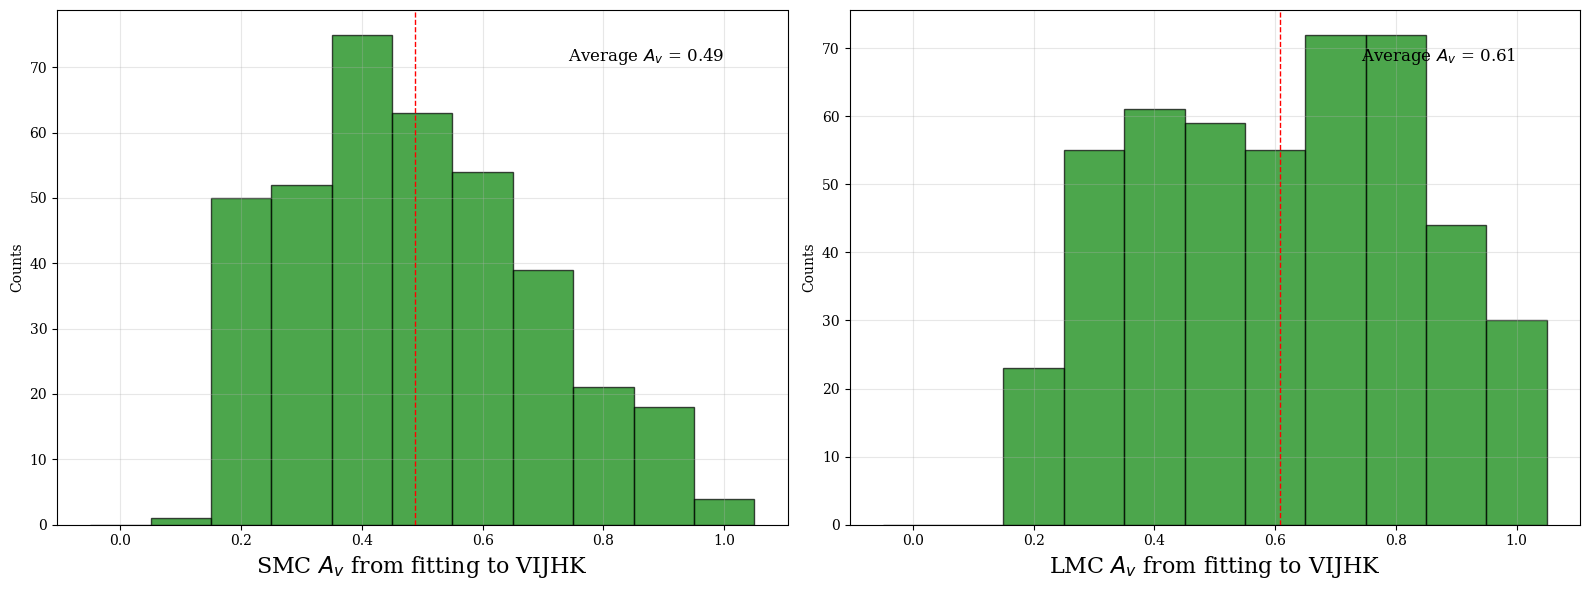

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

av_bins = np.arange(-0.05, 1.15, 0.1)
ax1.hist(temp_stats['av_mean_cut'][:377], bins=av_bins, color='green', alpha=0.7, edgecolor='black')
ax1.set_xlabel('SMC $A_v$ from fitting to VIJHK', fontsize=16)
average_av_smc = np.mean(temp_stats['av_mean_cut'][:377])
ax1.axvline(average_av_smc, color='red', linestyle='dashed', linewidth=1)
ax1.annotate(f'Average $A_v$ = {average_av_smc:.2f}', xy=(0.7, 0.9), xycoords='axes fraction', fontsize=12)
ax1.set_ylabel('Counts')
ax1.grid(True, alpha=0.3)

ax2.hist(temp_stats['av_mean_cut'][377:], bins=av_bins, color='green', alpha=0.7, edgecolor='black')
ax2.set_xlabel('LMC $A_v$ from fitting to VIJHK', fontsize=16)
average_av_lmc = np.mean(temp_stats['av_mean_cut'][377:])
ax2.axvline(average_av_lmc, color='red', linestyle='dashed', linewidth=1)
ax2.annotate(f'Average $A_v$ = {average_av_lmc:.2f}', xy=(0.7, 0.9), xycoords='axes fraction', fontsize=12)
ax2.set_ylabel('Counts')
ax2.grid(True, alpha=0.3)
# fig.text(0.5,-0.02, 'LMC', fontsize=22)

plt.tight_layout()
plt.show()

### Comparison showing which are binary candidates:

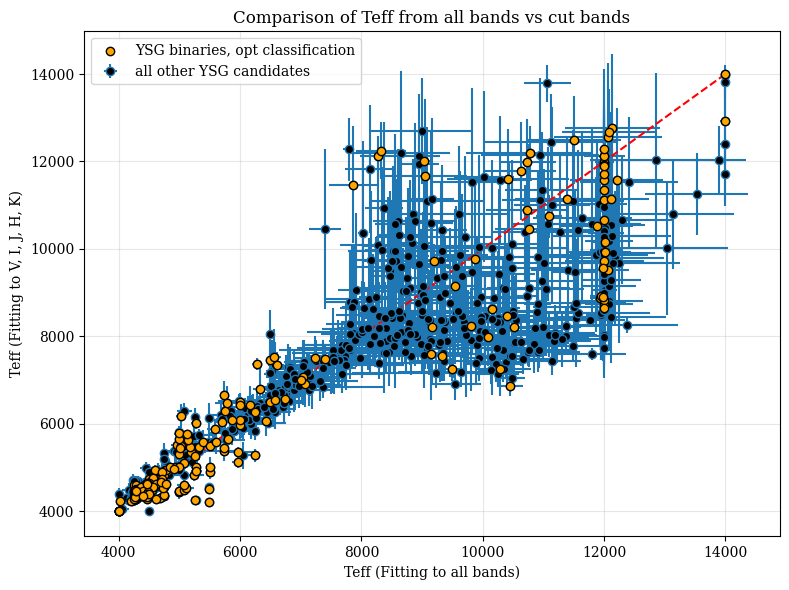

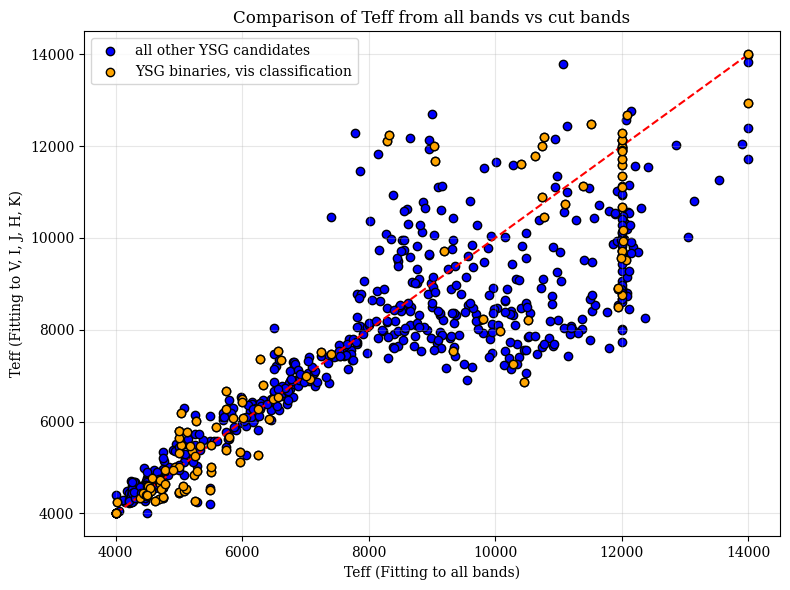

In [14]:
teff_allbands = temp_stats['teff_mean_full']
teff_cutbands = temp_stats['teff_mean_cut']
teff_fullstd = temp_stats['teff_std_full']
teff_cutstd = temp_stats['teff_std_cut']
chi2_cut = temp_stats['chi2_cut_mean']
chi2_full = temp_stats['chi2_full_mean']
yerr_full = [temp_stats['chi2_full_mean'] - temp_stats['teff_16perc_full'], temp_stats['teff_84perc_full'] - temp_stats['teff_mean_full']]
xerr_full = [temp_stats['teff_mean_full'] - temp_stats['teff_16perc_full'], temp_stats['teff_84perc_full'] - temp_stats['teff_mean_full']] 
yerr_cut = [temp_stats['logL_mean_cut'] - temp_stats['logL_16perc_cut'],temp_stats['logL_84perc_cut'] - temp_stats['logL_mean_cut']]
yerr_cut = [temp_stats['teff_mean_cut'] - temp_stats['teff_16perc_cut'],temp_stats['teff_84perc_cut'] - temp_stats['teff_mean_cut']]

# Binary identification from Anna 
smc_opt_bin = pd.read_csv('./annas_candidates/smc_opt_bin.csv')
lmc_opt_bin = pd.read_csv('./annas_candidates/lmc_opt_bin.csv')
all_opt_bin = pd.concat([smc_opt_bin, lmc_opt_bin], ignore_index=True)
smc_vis_bin = pd.read_csv('./annas_candidates/smc_vis_bin.csv')
lmc_vis_bin = pd.read_csv('./annas_candidates/lmc_vis_bin.csv')
all_vis_bin = pd.concat([smc_vis_bin, lmc_vis_bin], ignore_index=True)

#match up RAs and decs of all_opt_bin to temp_stats
matched_teff_allbands = []
matched_teff_cutbands = []
matched_chi2_cut = []
matched_chi2_full = []
for i, row in all_opt_bin.iterrows():
    ra = row['ra']
    dec = row['dec']
    match = temp_stats[(temp_stats['RA'] == ra) & (temp_stats['DEC'] == dec)]
    if not match.empty:
        matched_teff_allbands.append(match['teff_mean_full'].values[0])
        matched_teff_cutbands.append(match['teff_mean_cut'].values[0])
        matched_chi2_cut.append(match['chi2_cut_mean'].values[0])
        matched_chi2_full.append(match['chi2_full_mean'].values[0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(teff_allbands, teff_cutbands, xerr=teff_fullstd, yerr=teff_cutstd, c='black', marker='o', ecolor='tab:blue', markeredgecolor='tab:blue', ls='none', label='all other YSG candidates')
ax.scatter(matched_teff_allbands, matched_teff_cutbands, c='orange', edgecolor='k', label='YSG binaries, opt classification', zorder=10)
# ax.scatter(teff_allbands[444], teff_cutbands[444], edgecolor='r', label='target 444')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#match up RAs and decs of all_vis_bin to temp_stats
matched_teff_allbands = []
matched_teff_cutbands = []
matched_chi2_cut = []
matched_chi2_full = []
for i, row in all_vis_bin.iterrows():
    ra = row['ra']
    dec = row['dec']
    match = temp_stats[(temp_stats['RA'] == ra) & (temp_stats['DEC'] == dec)]
    if not match.empty:
        matched_teff_allbands.append(match['teff_mean_full'].values[0])
        matched_teff_cutbands.append(match['teff_mean_cut'].values[0])
        matched_chi2_cut.append(match['chi2_cut_mean'].values[0])
        matched_chi2_full.append(match['chi2_full_mean'].values[0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c='blue', edgecolor='k', label='all other YSG candidates')
ax.scatter(matched_teff_allbands, matched_teff_cutbands, c='orange', edgecolor='k', label='YSG binaries, vis classification', zorder=10)
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Comparison of fitting to U-redward vs V-redward:

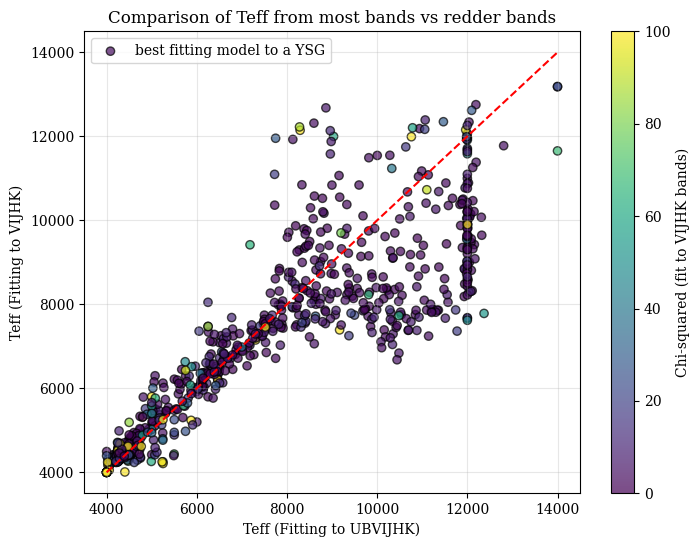

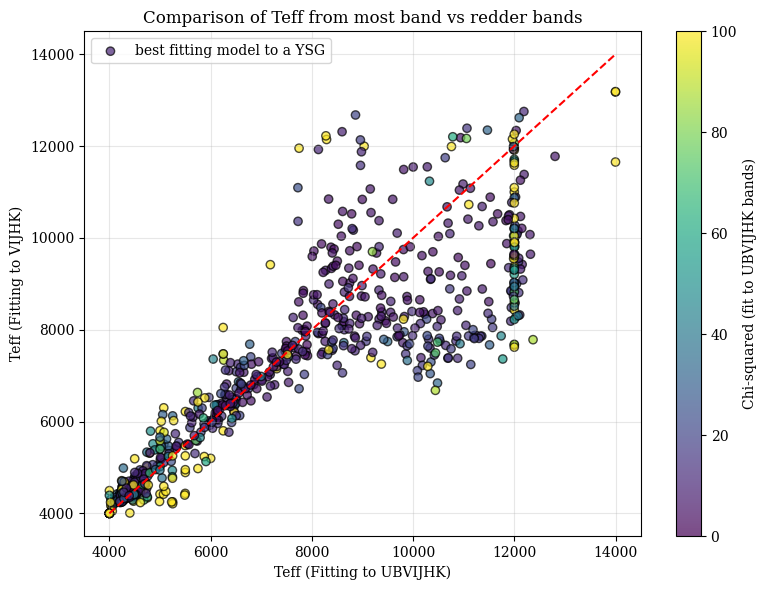

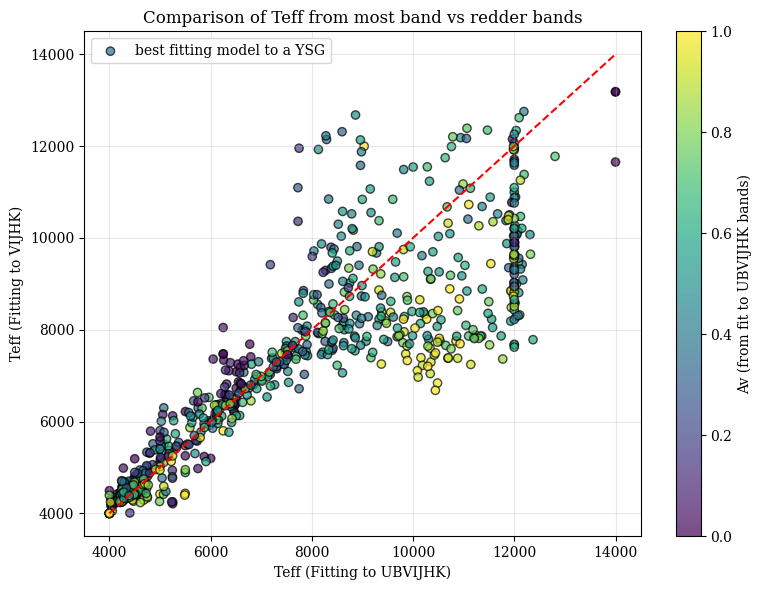

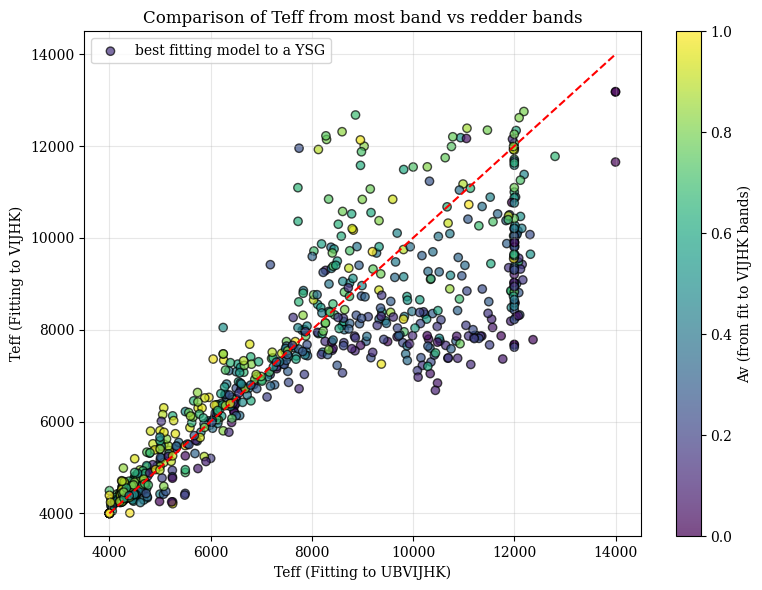

In [13]:
cbarmin = 0
cbarmax = 100

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=chi2_cut, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to UBVIJHK)')
ax.set_ylabel('Teff (Fitting to VIJHK)')
ax.set_title('Comparison of Teff from most bands vs redder bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to VIJHK bands)')
plt.grid(True, alpha=0.3)
# plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=chi2_full, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to UBVIJHK)')
ax.set_ylabel('Teff (Fitting to VIJHK)')
ax.set_title('Comparison of Teff from most band vs redder bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to UBVIJHK bands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=temp_stats['av_mean_full'], edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to UBVIJHK)')
ax.set_ylabel('Teff (Fitting to VIJHK)')
ax.set_title('Comparison of Teff from most band vs redder bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(0, 1)
cbar.set_label('Av (from fit to UBVIJHK bands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=temp_stats['av_mean_cut'], edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to UBVIJHK)')
ax.set_ylabel('Teff (Fitting to VIJHK)')
ax.set_title('Comparison of Teff from most band vs redder bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(0, 1)
cbar.set_label('Av (from fit to VIJHK bands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
counter = 0
for row in temp_stats.itertuples():
    if row.chi2_full_mean < row.chi2_cut_mean:
        counter += 1
print(f'Number of stars where fitting to all bands is better: {counter} out of {len(temp_stats)}')

Number of stars where fitting to all bands is better: 0 out of 848


### Comparison to J-K estimates:

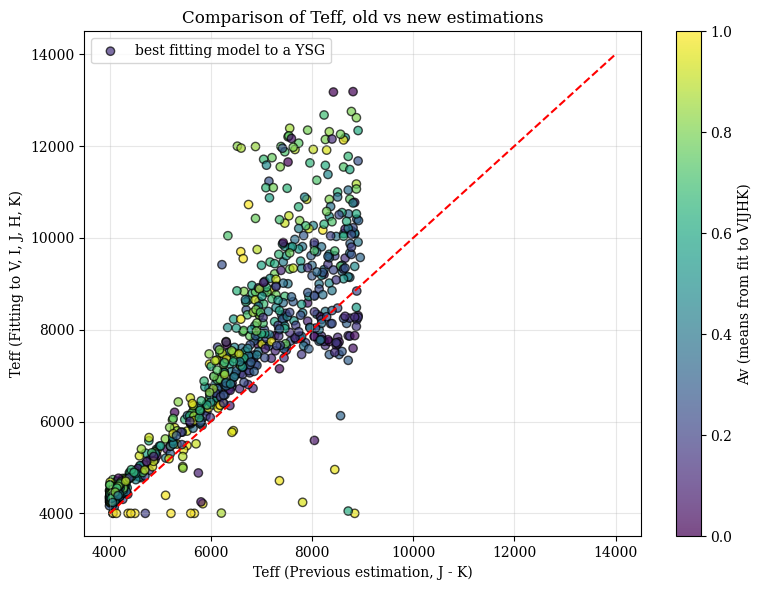

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']
teff_cutbands = temp_stats['teff_mean_cut']
teff_allbands = temp_stats['teff_mean_full']


# ax.scatter(10**x_old, teff_cutbands, c=chi2_cut, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.scatter(10**x_old, teff_cutbands, c=temp_stats['av_mean_cut'], edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Previous estimation, J - K)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff, old vs new estimations')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
# ax.collections[0].set_clim(cbarmin, cbarmax)
ax.collections[0].set_clim(0, 1)
cbar.set_label('Av (means from fit to VIJHK)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.save_fig()
plt.show()

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_5086/316597469.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax1.scatter(x_old, y_old, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')


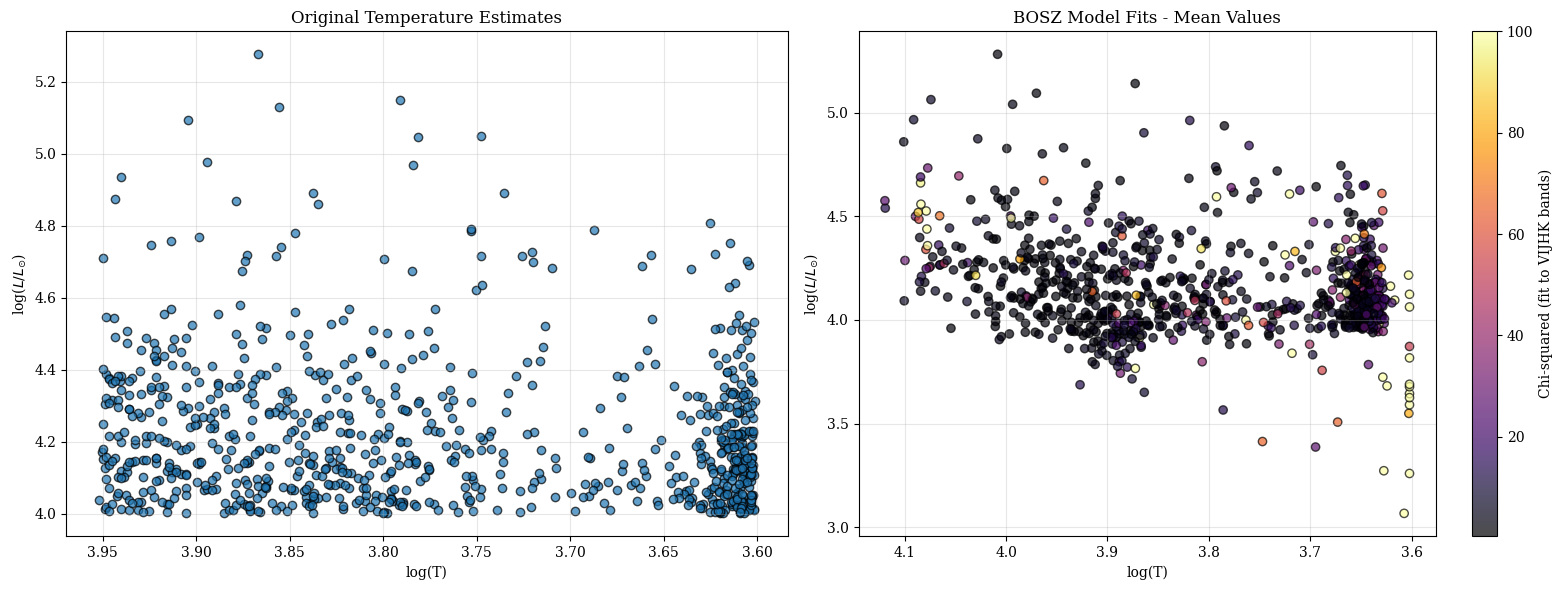

In [16]:
logT = temp_stats['logT_mean_cut']
logL = temp_stats['logL_mean_cut']
chi2_cut = temp_stats['chi2_cut_mean']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Old estimations
periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']
sc1 = ax1.scatter(x_old, y_old, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')
ax1.set_xlabel('log(T)')
ax1.set_ylabel('log($L/L_{\\odot}$)')
ax1.set_title('Original Temperature Estimates')
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)

sc = ax2.scatter(logT, logL, c=chi2_cut, edgecolor='k', label='new estimations', alpha=0.7, cmap='inferno', vmax=100)
# sc2 = ax2.scatter(logT.iloc[444], logL.iloc[444], c='red', edgecolor='k', label='target star 444')
# sc2 = ax2.scatter(logT.iloc[726], logL.iloc[726], c='red', edgecolor='k', label='target star 726')
ax2.set_xlabel('log(T)')
ax2.set_ylabel('log($L/L_{\\odot}$)')
ax2.set_title('BOSZ Model Fits - Mean Values')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Chi-squared (fit to VIJHK bands)')
# cbar.set_label('Period (days)')
plt.tight_layout()
plt.show()

### Wacky change-tracking diagram:

In [17]:
logT = temp_stats['logT_mean_cut']
logL = temp_stats['logL_mean_cut']

# Old estimations
periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for i in range(len(x_old)):
    dx = logT.iloc[i] - x_old.iloc[i]
    dy = logL.iloc[i] - y_old.iloc[i]

    ax.arrow(x_old.iloc[i], y_old.iloc[i], dx, dy,
            head_width=0.005, head_length=0.005, 
            fc='gray', ec='gray', alpha=0.6, linewidth=0.5)

dx_444 = logT.iloc[444] - x_old.iloc[444]
dy_444 = logL.iloc[444] - y_old.iloc[444]
ax.arrow(x_old.iloc[444], y_old.iloc[444], dx_444, dy_444,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)

dx_726 = logT.iloc[726] - x_old.iloc[726]
dy_726 = logL.iloc[726] - y_old.iloc[726]
ax.arrow(x_old.iloc[726], y_old.iloc[726], dx_726, dy_726,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)

dx_495 = logT.iloc[495] - x_old.iloc[495]
dy_495 = logL.iloc[495] - y_old.iloc[495]
ax.arrow(x_old.iloc[495], y_old.iloc[495], dx_495, dy_495,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)

dx_802 = logT.iloc[802] - x_old.iloc[802]
dy_802 = logL.iloc[802] - y_old.iloc[802]
ax.arrow(x_old.iloc[802], y_old.iloc[802], dx_802, dy_802,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)

dx_802 = logT.iloc[802] - x_old.iloc[802]
dy_802 = logL.iloc[802] - y_old.iloc[802]
ax.arrow(x_old.iloc[802], y_old.iloc[802], dx_802, dy_802,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)
dx_79 = logT.iloc[79] - x_old.iloc[79]
dy_79 = logL.iloc[79] - y_old.iloc[79]
ax.arrow(x_old.iloc[79], y_old.iloc[79], dx_79, dy_79,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)


ax.set_xlabel('log(T)')
ax.set_ylabel('log($L/L_{\\odot}$)')
ax.set_title('Temperature and Luminosity Changes: Old to New Estimates')
ax.invert_xaxis()
ax.grid(True, alpha=0.3)
ax.legend()

# cbar = plt.colorbar(sc1, ax=ax)
# cbar.set_label('Period (days)')
plt.tight_layout()
plt.show()

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_5086/3712655472.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
